In [106]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math

In [107]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/bridge"  

font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [110]:
import os
import re

data_dir = "/Users/asapp/Documents/VAST/sim_results/bridge/bridge"
groups = {}

pattern = re.compile(r"sim_data_map_(\d+\.\d+)_fit_(\d+\.\d+)_trial_\d+\.pkl")

for fname in os.listdir(data_dir):
    match = pattern.match(fname)
    if match:
        map_val = float(match.group(1))
        fit = float(match.group(2))
        key = (map_val, fit)
        groups.setdefault(key, []).append(os.path.join(data_dir, fname))

[0.002, 0.0008, 0.0002]


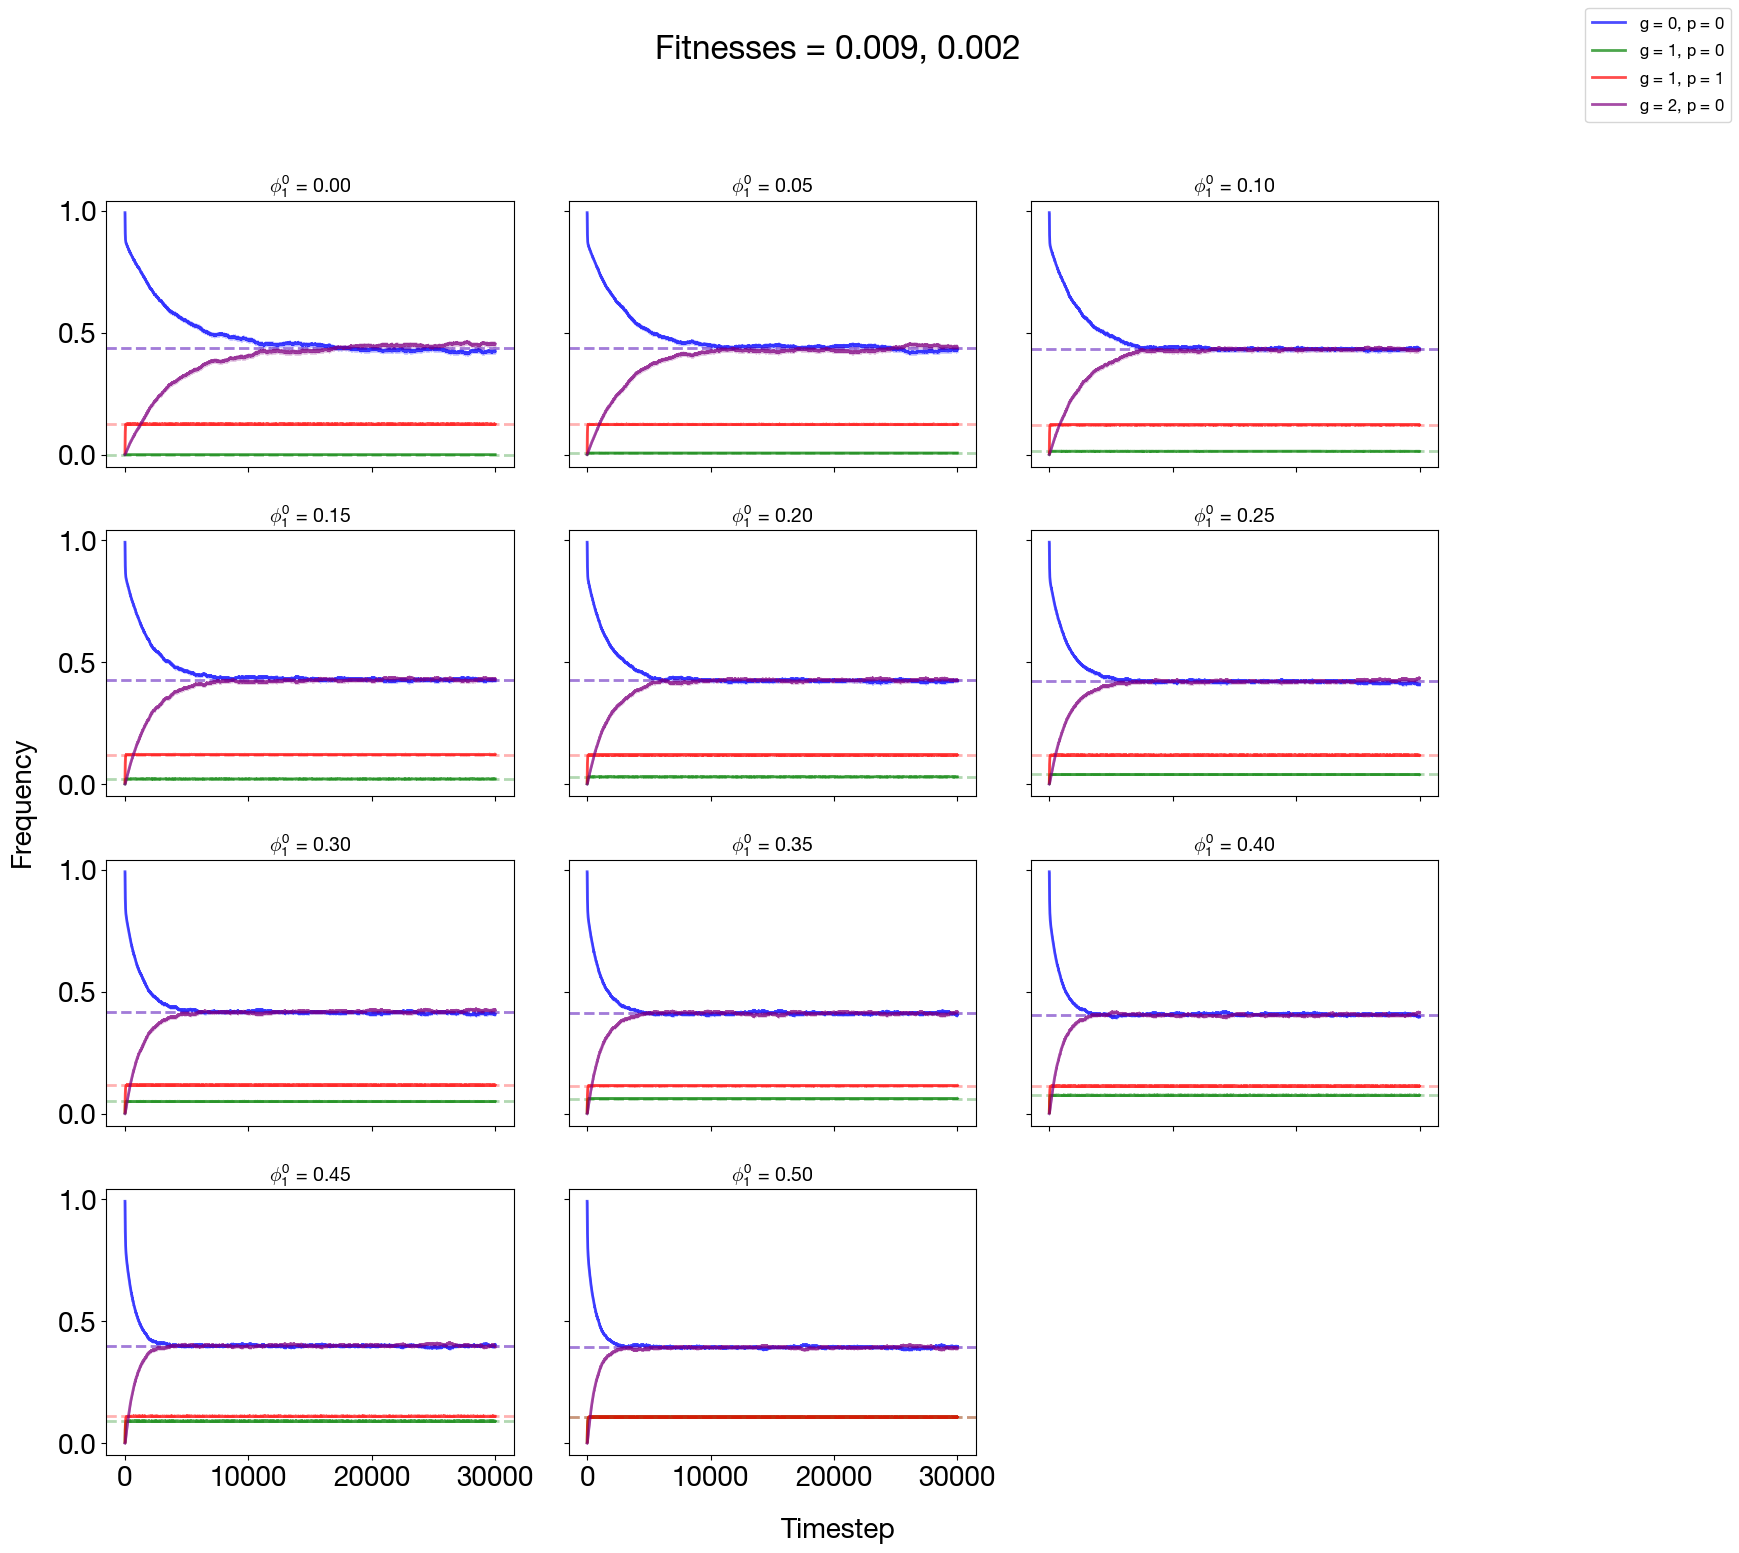

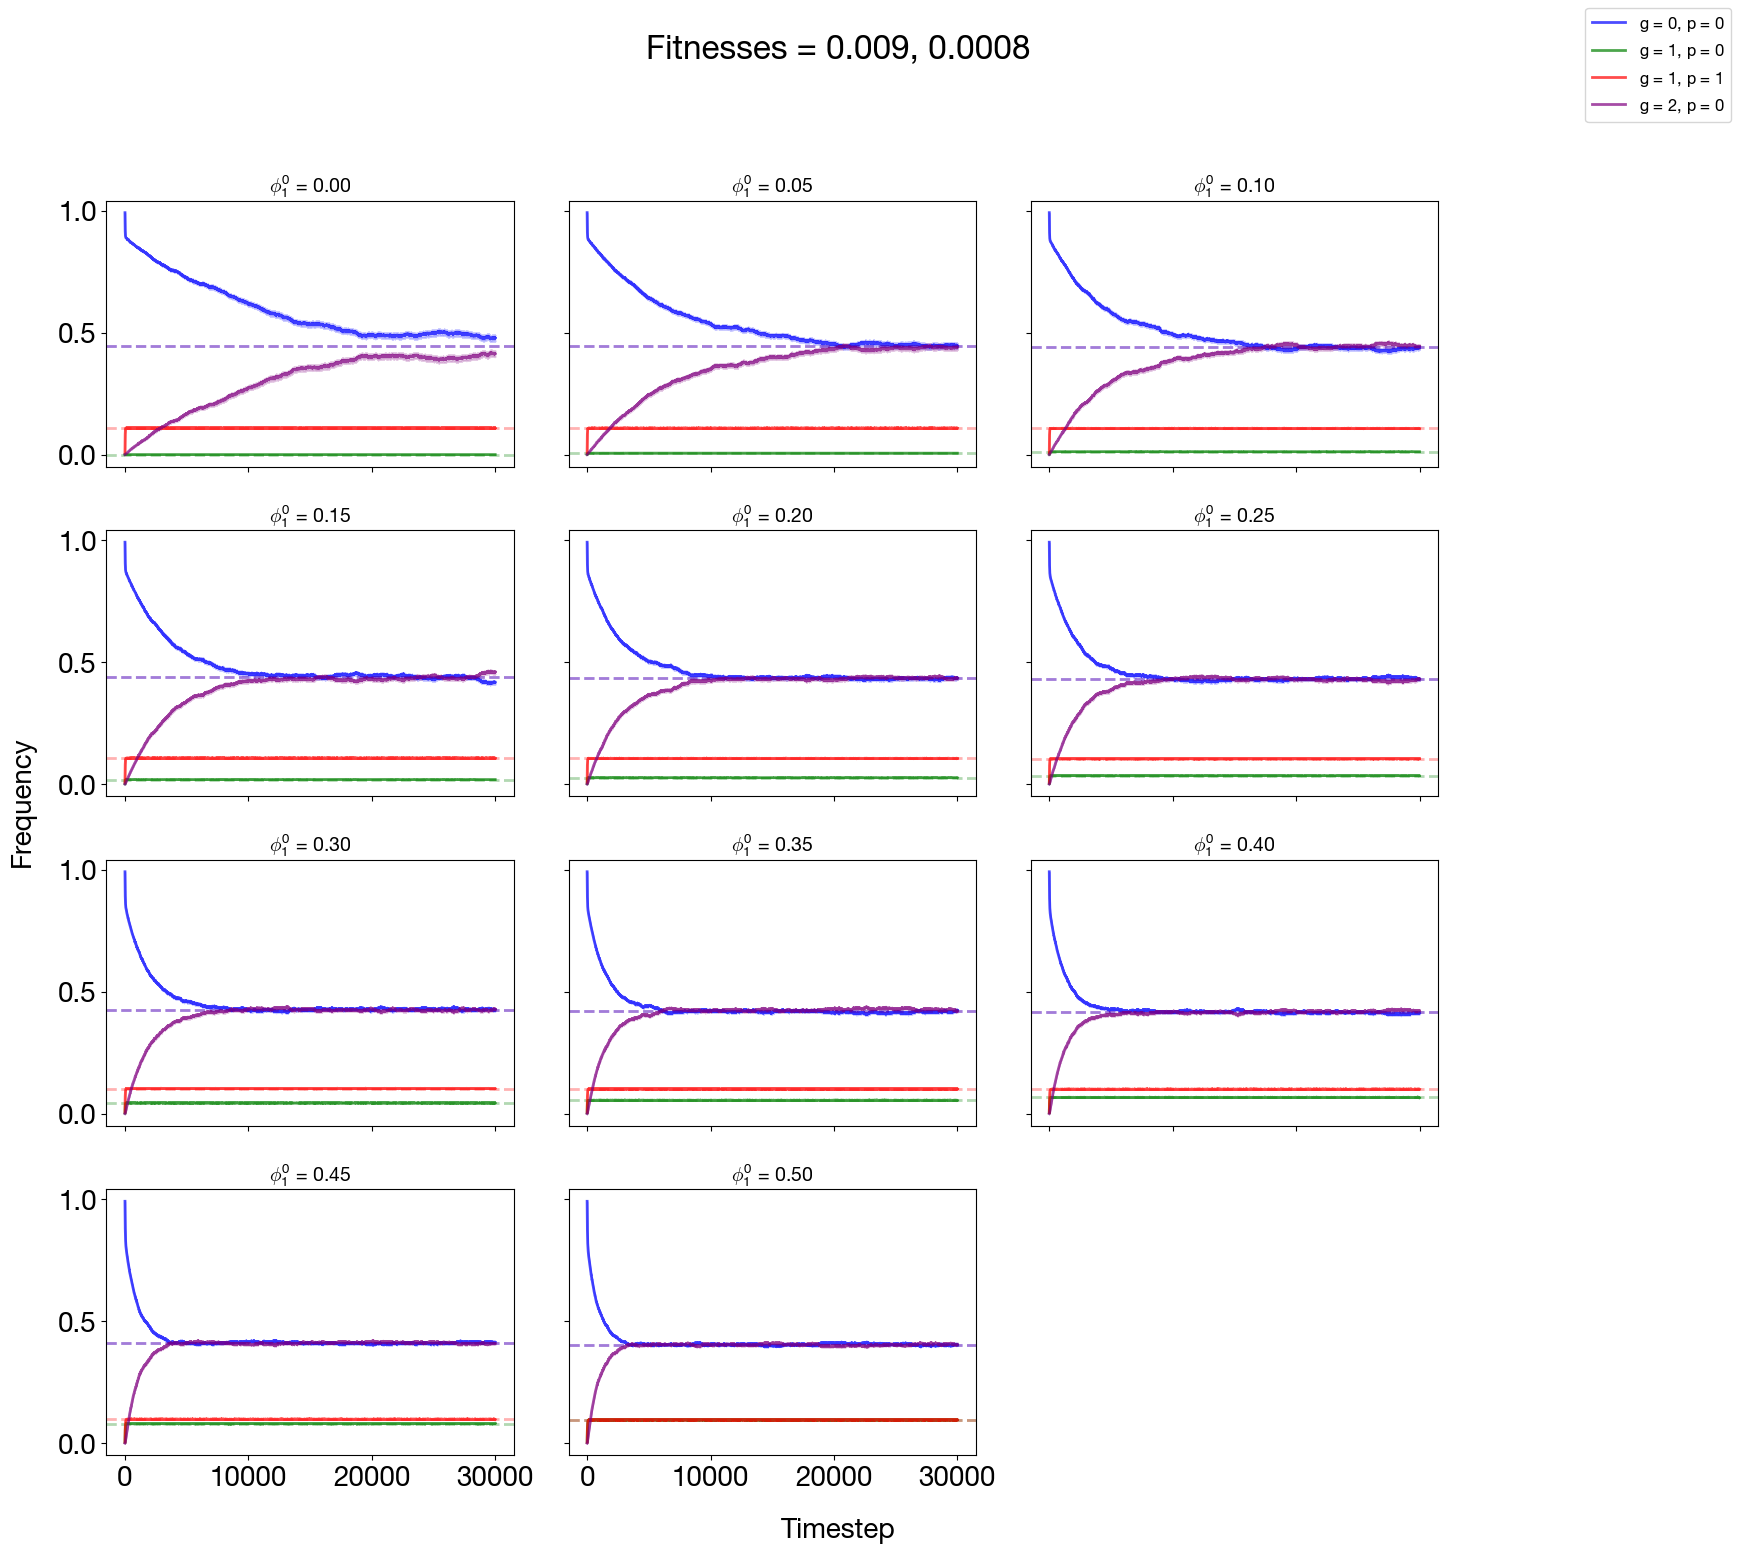

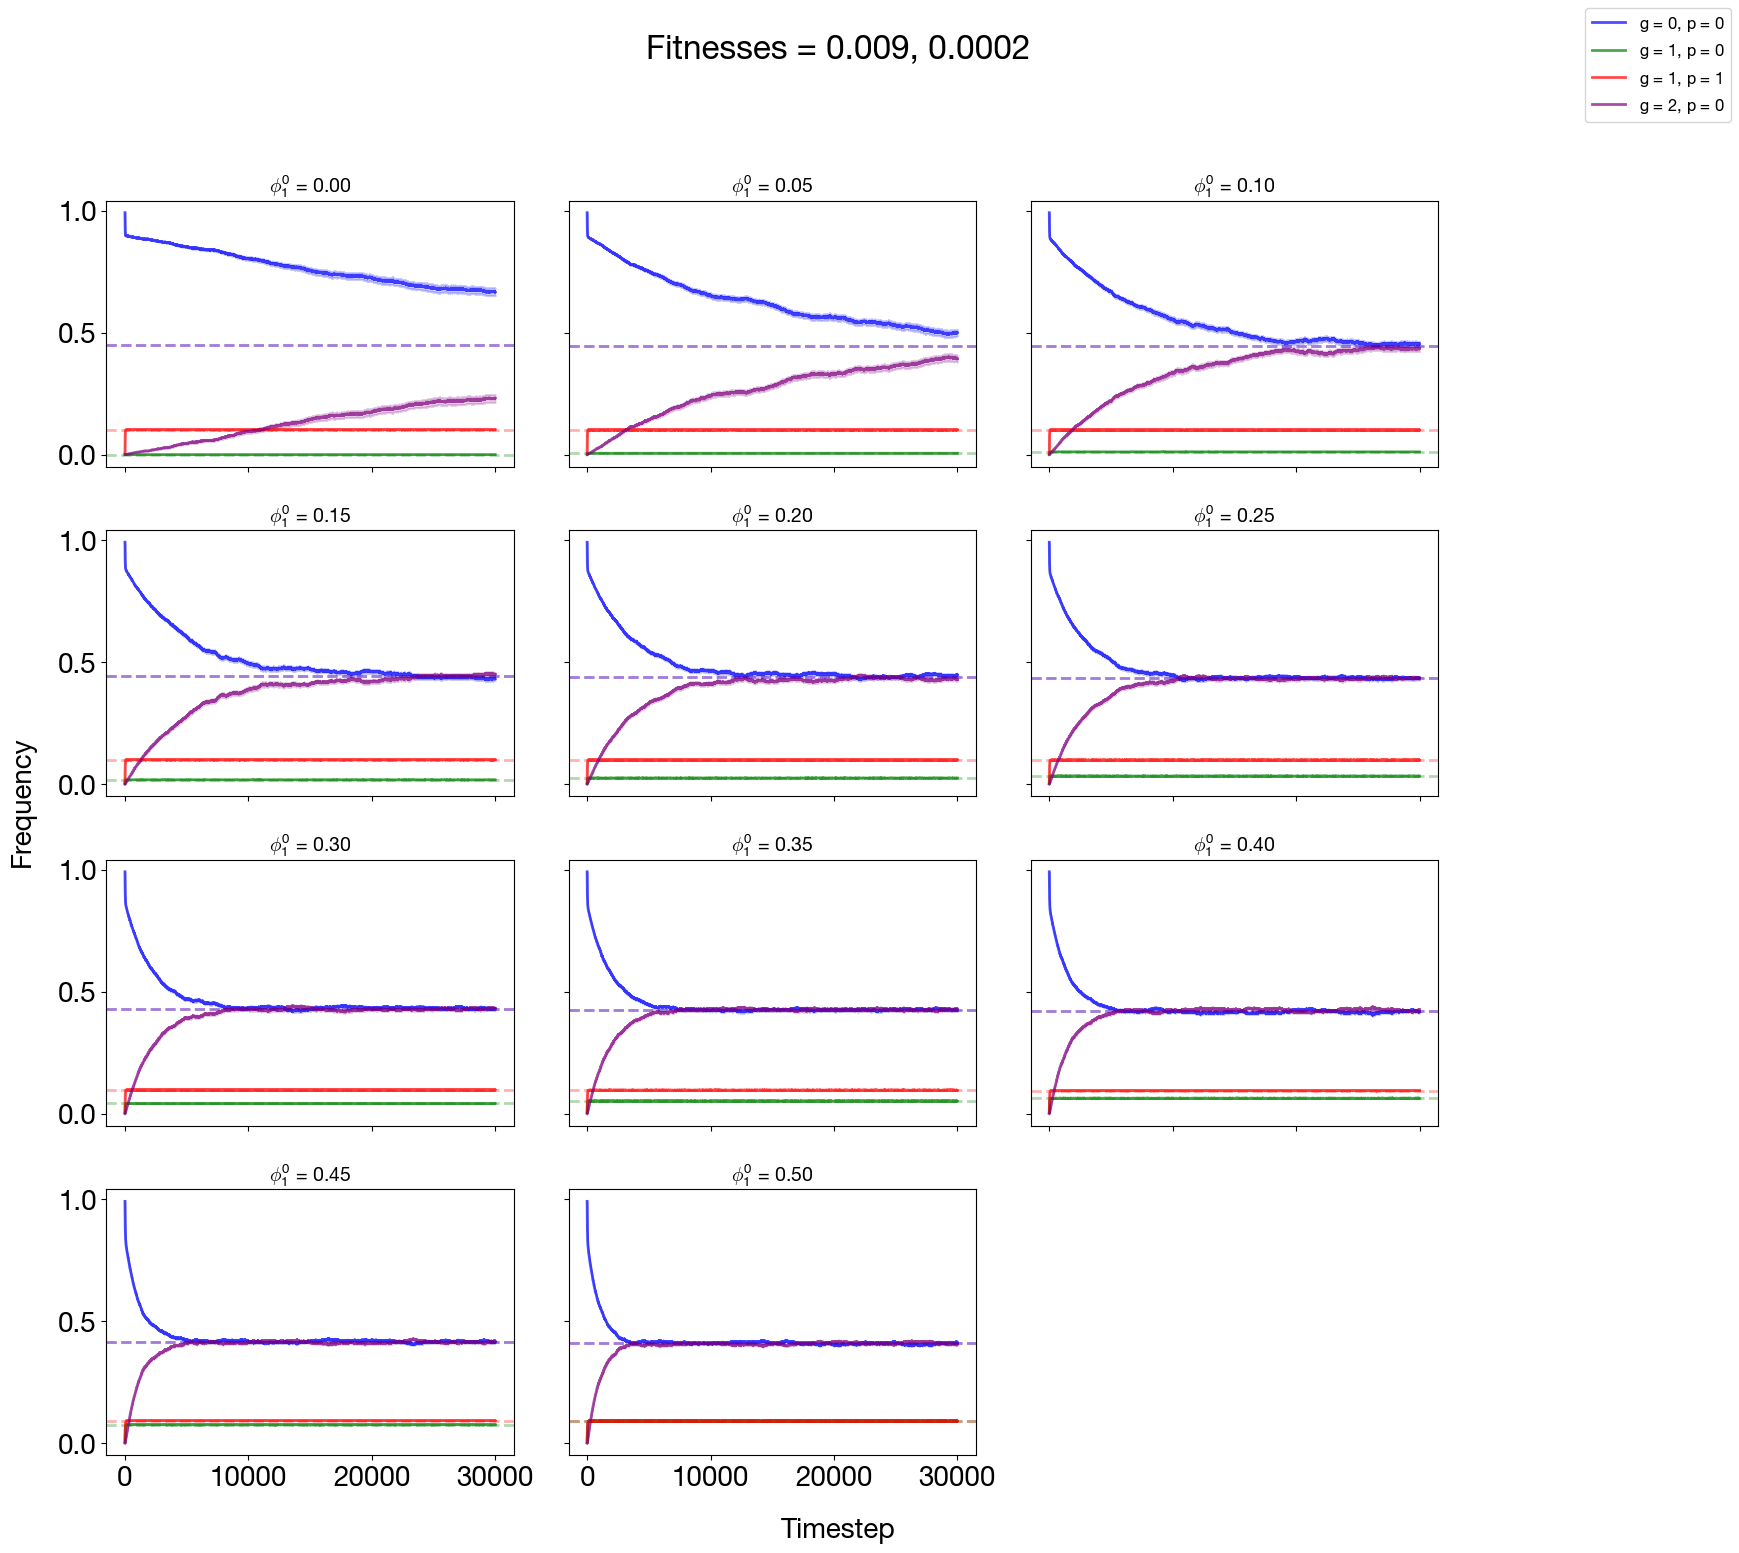

In [111]:
fits = sorted(set(f for (_, f) in groups.keys()), reverse=True)
print(fits)

# -------------------------
# Compute averages and plot in grids
# -------------------------
for fit in fits:
    # collect map values for this fit
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x),
        reverse=True   # so it goes 0.5 → 0.0
    )

    # keep only those ≤ 0.5
    map_vals = [m for m in map_vals if float(m) >= 0.5]

    n_maps = len(map_vals)
    ncols = 3  # adjust if you want
    nrows = math.ceil(n_maps / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), sharex=True, sharey=True)
    axes = axes.flatten()

    # define colors for selected pairs
    node_colors = {
        (0,0): "blue",
        (1,0): "green",
        (1,1): "red",
        (2,0): "purple"
    }

    for ax_idx, map_val in enumerate(map_vals):
        key = (map_val, fit)
        file_list = groups[key]

        trajectories = []

        # load all trials
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                trajectories.append(data["freq_timeseries"])
                theoretical_vals = np.array(data['f_eq']).reshape(3,2) # same for all

        trajectories = np.array(trajectories)  # (num_trials, Ng, Np, T)
        mean_traj = trajectories.mean(axis=0)
        sem_traj = trajectories.std(axis=0) / np.sqrt(len(trajectories))

        Ng, Np, T = mean_traj.shape
        timepoints = np.arange(T)

        # only plot selected pairs
        selected_pairs = [(0, 0), (1, 0), (1, 1), (2, 0)]

        ax = axes[ax_idx]

        # inside your plotting loop:
        for i in range(Ng):
            for j in range(Np):
                if (i, j) not in selected_pairs:
                    continue
                color = node_colors[(i,j)]
                line, = ax.plot(
                    timepoints,
                    mean_traj[i, j, :],
                    label=f'$g$ = {i}, $p$ = {j}',
                    alpha=0.7,
                    linewidth=2.0,
                    color=color
                )
                ax.fill_between(
                    timepoints,
                    mean_traj[i, j, :] - sem_traj[i, j, :],
                    mean_traj[i, j, :] + sem_traj[i, j, :],
                    alpha=0.2,
                    color=color
                )
                th = theoretical_vals[i, j]
                ax.axhline(th, linestyle="--", linewidth=2,
                        alpha=0.3, color=color)

        map_display = 1 - float(map_val)
        ax.set_title(f"$\phi_1^{0}$ = {map_display:.2f}", fontsize=14)

    # remove any unused subplots if grid isn’t full
    for k in range(ax_idx+1, len(axes)):
        fig.delaxes(axes[k])

    # add shared labels, legend once
    fig.text(0.5, 0.04, "Timestep", ha="center")
    fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=12, loc="upper right", ncol=1)

    fig.suptitle(f"Fitnesses = 0.009, {fit}")
    fig.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
    plt.savefig(f"/Users/asapp/Documents/VAST/r4_figs/bridge_{fit}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

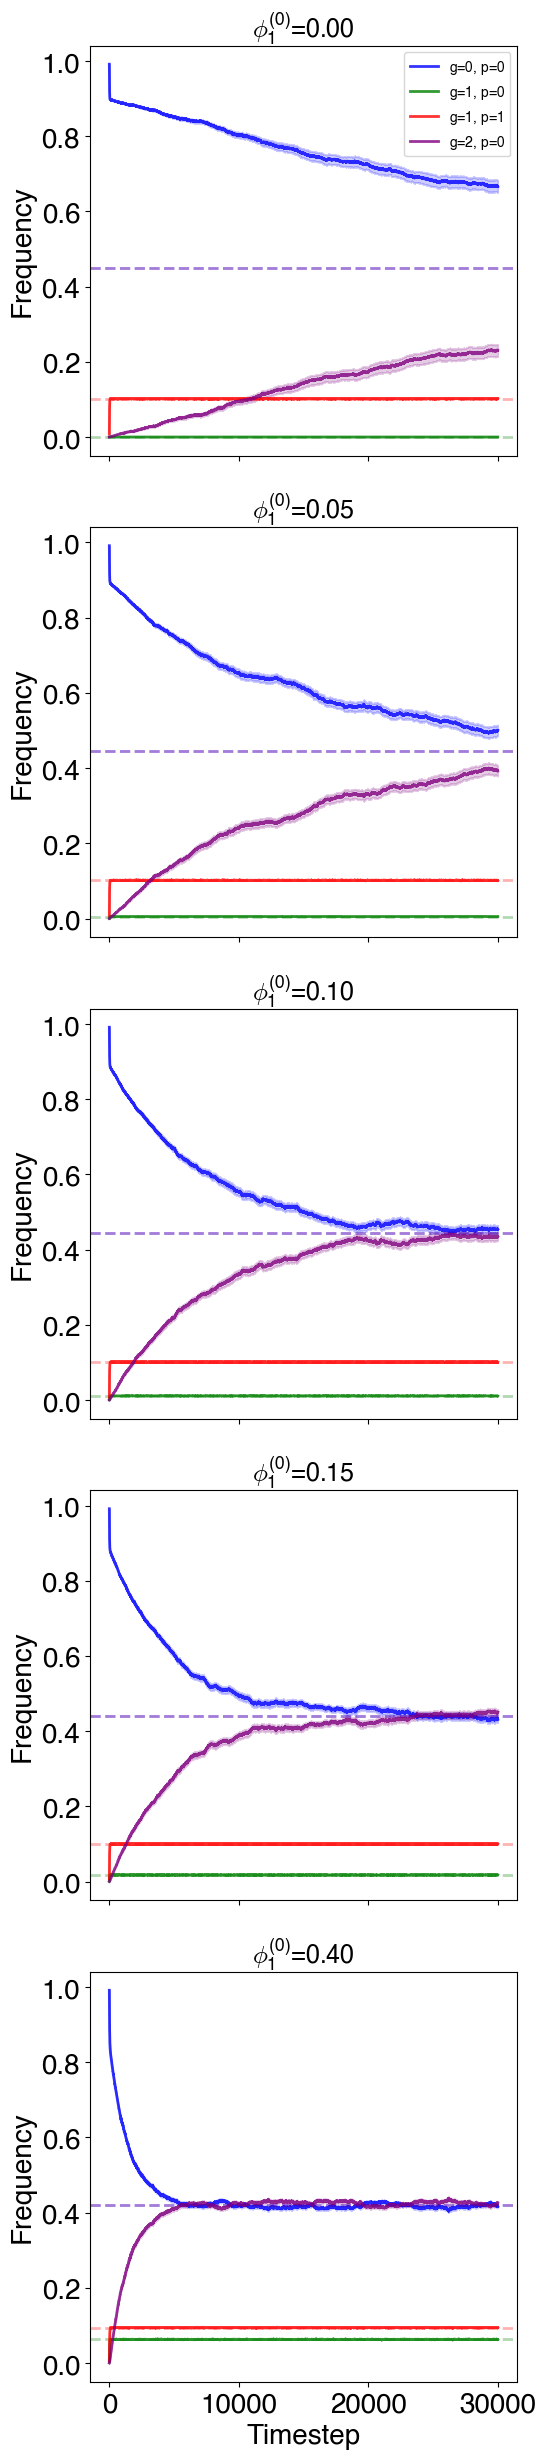

In [129]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "mathtext.fontset": "custom",
    "mathtext.rm": "Helvetica",
    "mathtext.it": "Helvetica:italic",
    "mathtext.bf": "Helvetica:bold"
})

# target fit value and phi values you want
target_fit = 0.0002
target_phis = [0.00, 0.05, 0.10, 0.15, 0.40]

# convert target phi values to corresponding map_vals (since phi = 1 - map_val)
target_map_vals = [1 - phi for phi in target_phis]

# define colors and pairs to plot
node_colors = {
    (0, 0): "blue",
    (1, 0): "green",
    (1, 1): "red",
    (2, 0): "purple"
}
selected_pairs = [(0, 0), (1, 0), (1, 1), (2, 0)]

# filter only desired map_vals present in groups
available_map_vals = sorted(
    [m for (m, f) in groups.keys() if f == target_fit and m in target_map_vals],
    key=float,
    reverse=True
)

# set up vertically stacked subplots
nrows = len(available_map_vals)
fig, axes = plt.subplots(nrows, 1, figsize=(6, 5 * nrows), sharex=True)
if nrows == 1:
    axes = [axes]

for idx, map_val in enumerate(available_map_vals):
    ax = axes[idx]
    key = (map_val, target_fit)
    file_list = groups[key]

    trajectories = []
    for fpath in file_list:
        with open(fpath, "rb") as f:
            data = pickle.load(f)
            trajectories.append(data["freq_timeseries"])
            theoretical_vals = np.array(data["f_eq"]).reshape(3, 2)

    trajectories = np.array(trajectories)
    mean_traj = trajectories.mean(axis=0)
    sem_traj = trajectories.std(axis=0) / np.sqrt(len(trajectories))

    Ng, Np, T = mean_traj.shape
    timepoints = np.arange(T)

    for i in range(Ng):
        for j in range(Np):
            if (i, j) not in selected_pairs:
                continue
            color = node_colors[(i, j)]
            ax.plot(
                timepoints,
                mean_traj[i, j, :],
                label=f"$g$={i}, $p$={j}",
                alpha=0.8,
                linewidth=2,
                color=color
            )
            ax.fill_between(
                timepoints,
                mean_traj[i, j, :] - sem_traj[i, j, :],
                mean_traj[i, j, :] + sem_traj[i, j, :],
                alpha=0.2,
                color=color
            )
            th = theoretical_vals[i, j]
            ax.axhline(th, linestyle="--", linewidth=2, alpha=0.3, color=color)

    phi_display = 1 - float(map_val)
    ax.set_title(f"$\\phi_1^{{(0)}}$={phi_display:.2f}", fontsize=18)
    ax.set_ylabel("Frequency")

axes[-1].set_xlabel("Timestep")
axes[0].legend(fontsize=10, loc="best")

plt.tight_layout()
for ax in axes:
    for artist in ax.get_children():
        if hasattr(artist, "set_rasterized"):
            artist.set_rasterized(True)
outpath = "/Users/asapp/Documents/VAST/r4_figs/bridge_fit0.0002_combined_rasterized.pdf"
plt.savefig(outpath, format="pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)


In [21]:
# ### ALL 

# # -------------------------
# # Compute averages and plot in grids
# # -------------------------
# for fit in fits:
#     map_vals = sorted(
#         set(map_val for (map_val, f) in groups.keys() if f == fit),
#         key=lambda x: float(x)
#     )

#     n_maps = len(map_vals)
#     ncols = 3  # you can adjust this (e.g. 3 columns per row)
#     nrows = math.ceil(n_maps / ncols)

#     fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), sharex=True, sharey=True)
#     axes = axes.flatten()

#     for ax_idx, map_val in enumerate(map_vals):
#         key = (map_val, fit)
#         file_list = groups[key]

#         trajectories = []

#         # load all trials
#         for fpath in file_list:
#             with open(fpath, "rb") as f:
#                 data = pickle.load(f)
#                 trajectories.append(data["freq_timeseries"])
#                 theoretical_vals = np.array(data['f_eq']).reshape(3,2) # same for all

#         trajectories = np.array(trajectories)  # (num_trials, Ng, Np, T)
#         mean_traj = trajectories.mean(axis=0)
#         sem_traj = trajectories.std(axis=0) / np.sqrt(len(trajectories))

#         Ng, Np, T = mean_traj.shape
#         timepoints = np.arange(T)

#         # only plot selected pairs
#         selected_pairs = [(0, 0), (1, 0), (1, 1), (2, 0)]

#         ax = axes[ax_idx]

#         for i in range(Ng):
#             for j in range(Np):
#                 if (i, j) not in selected_pairs:
#                     continue
#                 line, = ax.plot(
#                     timepoints,
#                     mean_traj[i, j, :],
#                     label=f'$g$ = {i}, $p$ = {j}',
#                     alpha=0.7,
#                     linewidth=2.0
#                 )
#                 ax.fill_between(
#                     timepoints,
#                     mean_traj[i, j, :] - sem_traj[i, j, :],
#                     mean_traj[i, j, :] + sem_traj[i, j, :],
#                     alpha=0.2,
#                     color=line.get_color()
#                 )
#                 th = theoretical_vals[i, j]
#                 ax.axhline(th, linestyle="--", linewidth=2,
#                            alpha=0.3, color=line.get_color())

#         map_display = 1 - float(map_val)
#         ax.set_title(f"Map = {map_display:.2f}", fontsize=14)

#     # remove any unused subplots if grid isn’t full
#     for k in range(ax_idx+1, len(axes)):
#         fig.delaxes(axes[k])

#     # add shared labels, legend once
#     fig.text(0.5, 0.04, "Timestep", ha="center", fontsize=16)
#     fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical", fontsize=16)

#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, fontsize=12, loc="upper right", ncol=1)

#     fig.suptitle(f"Fitness = {fit}", fontsize=18)
#     fig.tight_layout(rect=[0.03, 0.03, 0.85, 0.95])
#     plt.show()

### ODR 

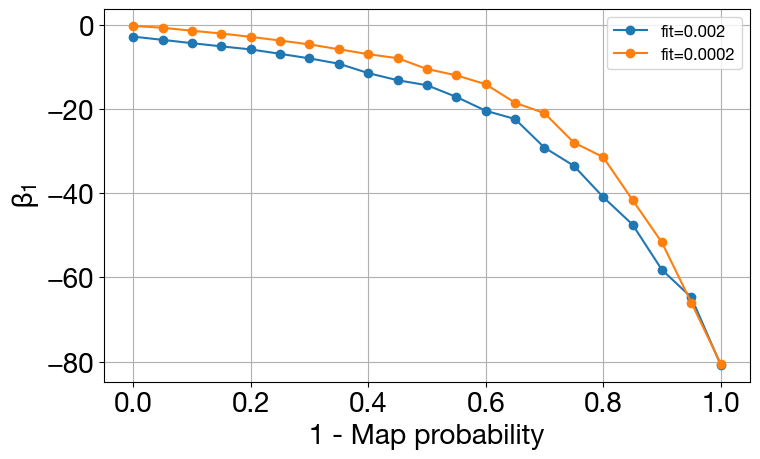

In [112]:
import matplotlib.pyplot as plt
from scipy import odr
import numpy as np
import pickle

# Settings
selected_node = (2,0)
fits = [0.002, 0.0002]

# Store beta_1 per fit
beta_dict = {fit: [] for fit in fits}  # fit -> list of (map, beta_1)

for fit in fits:
    # Collect map values for this fit
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x),
        reverse=True
    )

    for map_val in map_vals:
        key = (map_val, fit)
        file_list = groups[key]

        # Stack all trial trajectories for this (map, fit)
        trial_trajs = []
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                trial_trajs.append(np.array(data["freq_timeseries"]))  # shape (Ng,Np,T)
                f_eq = np.array(data['f_eq'])  # same for all trials

        trial_trajs = np.stack(trial_trajs, axis=0)  # (num_trials, Ng, Np, T)
        mean_traj = trial_trajs[:, selected_node[0], selected_node[1], :].mean(axis=0)
        eq_val = f_eq[4]

        # Subtract equilibrium
        diff = -(mean_traj - eq_val)

        timesteps = np.arange(mean_traj.shape[0])

        # --- ODR exponential fit ---
        def exp_func(beta, x):
            return beta[0] * np.exp(beta[1] * x) 

        model = odr.Model(exp_func)
        scaled_timesteps = timesteps / 10000.0
        data_odr = odr.Data(scaled_timesteps, diff)
        odr_obj = odr.ODR(data_odr, model, beta0=[1.0, -0.001])
        output = odr_obj.run()

        beta_1 = output.beta[1]
        beta_dict[fit].append((float(map_val), beta_1))

        # Evaluate fitted curve 
        # fitted_curve = exp_func(output.beta, scaled_timesteps)

        # --- Plot individual trajectory + fit ---
        # plt.figure(figsize=(8, 4))
        # plt.plot(timesteps, diff, color='black', lw=2, label='Data')
        # plt.plot(timesteps, fitted_curve, color='red', lw=2, linestyle='--', label='ODR fit')
        # plt.xlabel("Timestep")
        # plt.ylabel(r"-($f(t) - f_{eq})$")
        # # plt.title(f"Node {selected_node}, Fit={fit}, Map={map_val}, β₁={beta_1:.3e}")
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

# -------------------------
# Global plot: beta_1 vs 1 - map probability (map probability is inverted)
# -------------------------
plt.figure(figsize=(8,5))
for fit in fits:
    vals = sorted(beta_dict[fit], key=lambda x: x[0])
    maps = [1 - m for m,_ in vals]
    betas = [b for _,b in vals]
    plt.plot(maps, betas, marker='o', label=f"fit={fit}")

plt.xlabel("1 - Map probability")
plt.ylabel(r"$\beta_1$")
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

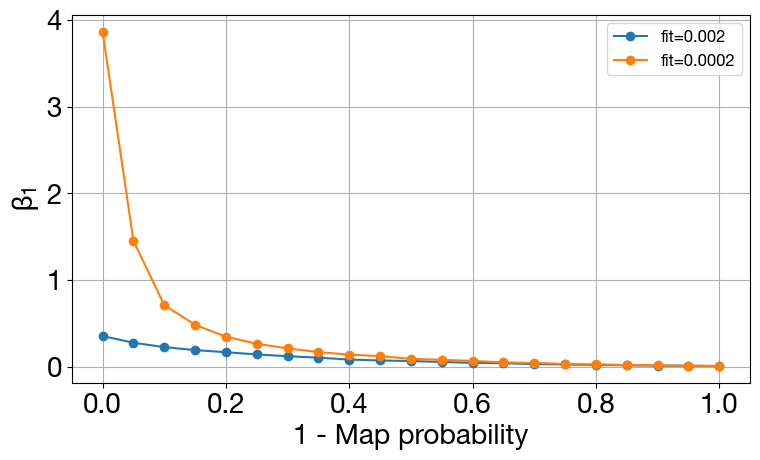

In [113]:
import matplotlib.pyplot as plt
from scipy import odr
import numpy as np
import pickle

# Settings
selected_node = (2,0)
fits = [0.002, 0.0002]

# Store beta_1 per fit
beta_dict = {fit: [] for fit in fits}  # fit -> list of (map, beta_1)

for fit in fits:
    # Collect map values for this fit
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x),
        reverse=True
    )

    for map_val in map_vals:
        key = (map_val, fit)
        file_list = groups[key]

        # Stack all trial trajectories for this (map, fit)
        trial_trajs = []
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                trial_trajs.append(np.array(data["freq_timeseries"]))  # shape (Ng,Np,T)
                f_eq = np.array(data['f_eq'])  # same for all trials

        trial_trajs = np.stack(trial_trajs, axis=0)  # (num_trials, Ng, Np, T)
        mean_traj = trial_trajs[:, selected_node[0], selected_node[1], :].mean(axis=0)
        eq_val = f_eq[4]

        # Subtract equilibrium
        diff = -(mean_traj - eq_val)

        timesteps = np.arange(mean_traj.shape[0])

        # --- ODR exponential fit ---
        def exp_func(beta, x):
            return beta[0] * np.exp(beta[1] * x) 

        model = odr.Model(exp_func)
        scaled_timesteps = timesteps / 10000.0
        data_odr = odr.Data(scaled_timesteps, diff)
        odr_obj = odr.ODR(data_odr, model, beta0=[1.0, -0.001])
        output = odr_obj.run()

        beta_1 = output.beta[1]
        beta_dict[fit].append((float(map_val), beta_1))

        # Evaluate fitted curve 
        # fitted_curve = exp_func(output.beta, scaled_timesteps)

        # --- Plot individual trajectory + fit ---
        # plt.figure(figsize=(8, 4))
        # plt.plot(timesteps, diff, color='black', lw=2, label='Data')
        # plt.plot(timesteps, fitted_curve, color='red', lw=2, linestyle='--', label='ODR fit')
        # plt.xlabel("Timestep")
        # plt.ylabel(r"-($f(t) - f_{eq})$")
        # # plt.title(f"Node {selected_node}, Fit={fit}, Map={map_val}, β₁={beta_1:.3e}")
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

# -------------------------
# Global plot: beta_1 vs 1 - map probability (map probability is inverted)
# -------------------------
plt.figure(figsize=(8,5))
for fit in fits:
    vals = sorted(beta_dict[fit], key=lambda x: x[0])
    maps = [1-m for m,_ in vals]
    betas = [-1/b for _,b in vals]
    plt.plot(maps, betas, marker='o', label=f"fit={fit}")

plt.xlabel("1 - Map probability")
plt.ylabel(r"$\beta_1$")
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

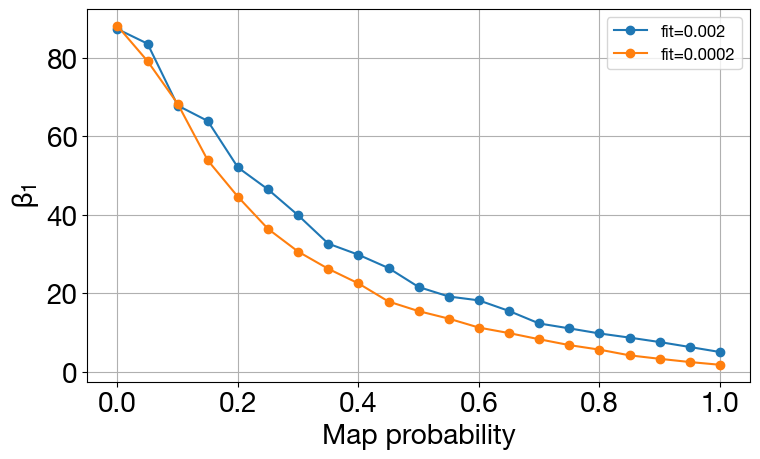

In [114]:
import matplotlib.pyplot as plt
from scipy import odr
import numpy as np
from collections import defaultdict
import pickle

selected_node = (2,0)

# store beta_1 per fit
beta_dict = {fit: [] for fit in fits}  # fit -> list of (map, beta_1)

for fit in fits:
    # collect map values for this fit
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x),
        reverse=True
    )

    for map_val in map_vals:
        key = (map_val, fit)
        file_list = groups[key]

        # Stack all trial trajectories for this (map, fit)
        trial_trajs = []
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                trial_trajs.append(np.array(data["freq_timeseries"]))  # shape (Ng,Np,T)
                f_eq = np.array(data['f_eq'])  # same for all trials

        trial_trajs = np.stack(trial_trajs, axis=0)  # (num_trials, Ng, Np, T)
        mean_traj = trial_trajs[:, selected_node[0], selected_node[1], :].mean(axis=0)
        eq_val = f_eq[5]

        # Subtract equilibrium
        diff = -(mean_traj - eq_val)
        timesteps = np.arange(len(diff))

        # --- ODR exponential fit ---
        def exp_func(beta, x):
            return beta[0] * np.exp(beta[1] * x)

        model = odr.Model(exp_func)
        scaled_timesteps = timesteps / 10000.0
        data_odr = odr.Data(scaled_timesteps, diff)
        odr_obj = odr.ODR(data_odr, model, beta0=[1.0, -0.1])
        output = odr_obj.run()

        beta_1 = output.beta[1]
        beta_dict[fit].append((float(map_val), beta_1))

# -------------------------
# Plot beta_1 vs 1 - map probability
# -------------------------

plt.figure(figsize=(8,5))
for fit in fits:
    vals = sorted(beta_dict[fit], key=lambda x: x[0])
    maps = [m for m,_ in vals]
    betas = [1 /b for _,b in vals]
    # inv_betas = 1 / np.array(betas)
    plt.plot(maps, betas, marker='o', label=f"fit={fit}")


plt.xlabel("Map probability")
plt.ylabel(r"$\beta_1$")
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
### Final plot ####

################## Theory #####################

def Theta(p, gamma):
    """θ(p, γ) = p + γ(1 - p)"""
    return p + gamma * (1 - p)

def x_eq(p, gamma, mu):
    """Equilibrium mean fitness (dimensionless form)."""
    theta = Theta(p, gamma)
    return ((1 + theta) * (1 - mu) +
            np.sqrt((1 + theta)**2 * (1 - mu)**2 - 4 * theta * (1 - 2 * mu))) / 2

def tau_theory(p_array, gamma, mu):
    """Relaxation time constant τ = -1 / (1 - μ - x_eq)."""
    xvals = x_eq(p_array, gamma, mu)
    return -1.0 / (1 - mu - xvals)

# Example usage:
p_vals = np.arange(0, 1.01, 0.01)  # analogous to Mathematica's p range
gamma = 2/90
mu = 0.1

tau_theory_vals = tau_theory(p_vals, gamma, mu)

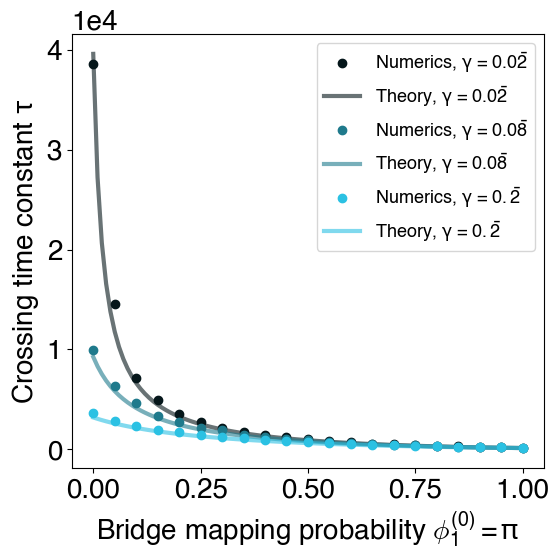

In [131]:
import matplotlib.pyplot as plt
from scipy import odr
import numpy as np
import pickle
from matplotlib.ticker import ScalarFormatter

fit_colors = {
    0.0002: "#05161a",
    0.0008: "#1f7a8c", 
    0.002: "#2bc1e3" # "",
} 

fit_labels = {
    0.0002: "$\\gamma$ = $0.0\\bar{2}$",
    0.0008: "$\\gamma$ = $0.0\\bar{8}$",
    0.002: "$\\gamma$ = $0.\\bar{2}$",
}

selected_node = (2,0)
fits = [0.0002, 0.0008, 0.002] 

# store beta_1 per fit
beta_dict = {fit: [] for fit in fits}  # fit -> list of (map, beta_1)

for fit in fits:
    # Collect map values for this fit
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x),
        reverse=True
    )

    for map_val in map_vals:
        key = (map_val, fit)
        file_list = groups[key]

        # Stack all trial trajectories for this (map, fit)
        trial_trajs = []
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                trial_trajs.append(np.array(data["freq_timeseries"]))  # shape (Ng,Np,T)
                f_eq = np.array(data['f_eq'])  # same for all trials

        trial_trajs = np.stack(trial_trajs, axis=0)  # (num_trials, Ng, Np, T)
        mean_traj = trial_trajs[:, selected_node[0], selected_node[1], :].mean(axis=0)
        eq_val = f_eq[4]

        # Subtract equilibrium
        diff = -(mean_traj - eq_val)

        timesteps = np.arange(mean_traj.shape[0])

        # --- ODR exponential fit ---
        def exp_func(beta, x):
            return beta[0] * np.exp(beta[1] * x) 

        model = odr.Model(exp_func)
        data_odr = odr.Data(timesteps, diff)
        odr_obj = odr.ODR(data_odr, model, beta0=[1.0, -0.001])
        output = odr_obj.run()

        beta_1 = output.beta[1]
        beta_dict[fit].append((float(map_val), beta_1))

# -------------------------
# Global plot: -1/beta_1 vs 1 - map probability (map probability is inverted)
# -------------------------
plt.figure(figsize=(6,6))
for fit in fits:
    vals = sorted(beta_dict[fit], key=lambda x: x[0])
    maps = [1-m for m,_ in vals]
    tau_exp = np.array([-1/b for _,b in vals])

    # compute γ value
    gamma = fit / 0.009
    tau_theory_vals = tau_theory(p_vals, gamma, mu)

    # pick color for this fit
    color = fit_colors.get(fit)

    # label string uses γ value
    label_str = fit_labels.get(fit)

    # Plot numerics
    plt.plot(
        maps, tau_exp,
        marker='o', linestyle='none',
        label=f"Numerics, {label_str}",
        color=color
    )

    # Plot theory (smooth curve)
    plt.plot(
        p_vals, tau_theory_vals * 10,
        linestyle='-', alpha=0.6,
        label=f"Theory, {label_str}",
        color=color, linewidth=3.0
    )
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.xlabel("Bridge mapping probability $\phi_1^{(0)} = \pi$")
plt.ylabel("Crossing time constant $\\tau$")
plt.legend(fontsize=13)

for ax in axes:
    for artist in ax.get_children():
        if hasattr(artist, "set_rasterized"):
            artist.set_rasterized(True)
outpath = "/Users/asapp/Documents/VAST/r4_figs/bridge_tau_rasterized.pdf"
plt.savefig(outpath, format="pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()